<a href="https://colab.research.google.com/github/rpdahxn/GANsInAction/blob/main/ch07_SGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### 7.2.4 데이터셋  
레이블된 것 + 레이블이 없는 것

In [8]:
class Dataset:
    def __init__(self, num_labeled):

        # 훈련에 사용할 레이블된 샘플 개수
        self.num_labeled = num_labeled

        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # [0, 255] 사이 흑백 픽셀 값을 [–1, 1]로 변환
            x = (x.astype(np.float32) - 127.5) / 127.5
            # 너비 × 높이 × 채널로 이미지 차원을 확장
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [9]:
num_labeled = 100
dataset = Dataset(num_labeled)

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자의 입력으로 사용할 잡음 벡터의 크기
z_dim = 100

# 데이터셋에 있는 클래스 개수
num_classes = 10

### 7.2.5 생성자

In [11]:
def build_generator(z_dim):

  model = Sequential()

  # 완전 연결 층을 사용해 입력을 7x7x256 크기 텐서로 바꾼다.
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))

  # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
  model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(alpha = 0.01))

  # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
  model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = 'same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(alpha = 0.01))

  # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
  model.add(Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = 'same'))

  # tanh활성화 함수
  model.add(Activation('tanh'))

  return model

### 7.2.6 판별자

In [12]:
def build_discriminator_net(img_shape):

  model = Sequential()

  # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
  model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = img_shape, padding = "same"))

  model.add(LeakyReLU(alpha = 0.01))

  # 14x14x32에서 7x7x64텐서로 바꾸는 합성곱 층
  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = "same"))

  model.add(LeakyReLU(alpha = 0.01))

  # 7x7x64에서 3x3x128텐서로 바꾸는 합성곱 층
  model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = "same"))

  model.add(LeakyReLU(alpha = 0.01))

  model.add(Dropout(0.5))

  model.add(Flatten())

  # num_classes 개의 뉴런을 가진 완전 연결 층
  model.add(Dense(num_classes))

  return model 

In [13]:
def build_discriminator_supervised(discriminator_net):

  model = Sequential()

  model.add(discriminator_net)

  # 진짜 클래스에 대한 예측 확률을 출력하는 소프트맥스 활성화 함수
  model.add(Activation('softmax'))

  return model

In [14]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # 진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환합니다.
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 앞서 정의한 진짜 대 가짜 확률을 출력하는 뉴런
    model.add(Lambda(predict))

    return model

### 7.2.7 GAN 모델 구성

In [15]:
def build_gan(generator, discriminator):

  model = Sequential()

  # 생성자와 판별자 모델을 연결
  model.add(generator)
  model.add(discriminator)

  return model

판별자

In [16]:
# 판별자 기반 모델 : 지도 학습 훈련과 비지도 학습 훈련에 공유된다.
discriminator_net = build_discriminator_net(img_shape)

# 지도 학습 훈련을 위해 판별자를 만들고 컴파일한다.
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss = "categorical_crossentropy",
                                 metrics = ["accuracy"],
                                 optimizer = Adam(learning_rate = 0.0003))

# 비지도 학습 훈련을 위해 판별자를 만들고 컴파일
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss = "binary_crossentropy", optimizer = Adam())

생성자

In [17]:
generator = build_generator(z_dim)

# 생성자 훈련을 위해 판별자의 모델 파라미터를 동결
discriminator_unsupervised.trainable = False

# 생성자 훈련을 위해 고정된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss = "binary_crossentropy", optimizer = Adam())

### 7.2.8 훈련

In [18]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # 진짜 이미지의 레이블, 모두 1
  real = np.ones((batch_size, 1))

  # 가짜 이미지 레이블
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    
    # 판별자 훈련

    imgs, labels = dataset.batch_labeled(batch_size)

    # 레이블 원-핫 인코딩
    labels = to_categorical(labels, num_classes = num_classes)

    # 레이블이 없는 샘플 가져오기
    imgs_unlabeled = dataset.batch_unlabeled(batch_size)

    # 가짜 이미지의 배치 생성
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    # 레이블된 진짜 샘플에서 훈련
    d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

    # 레이블이 없는 진짜 샘플에서 훈련
    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)

    # 가짜 샘플에서 훈련
    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

    d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)


    # 생성자 훈련

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

    if (iteration + 1) % sample_interval == 0:

      supervised_losses.append(d_loss_supervised)
      iteration_checkpoints.append(iteration + 1)

      print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

In [19]:
# 하이퍼파라미터
iterations = 8000
batch_size = 32
sample_interval = 800

# 지정한 반복 횟수 동안 SGAN을 훈련
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.7522, acc.: 75.00%] [D loss unsupervised: 0.2699] [G loss: 2.239711]
1600 [D loss supervised: 0.1069, acc.: 100.00%] [D loss unsupervised: 0.4206] [G loss: 1.914994]
2400 [D loss supervised: 0.0405, acc.: 100.00%] [D loss unsupervised: 0.4431] [G loss: 2.213883]
3200 [D loss supervised: 0.0381, acc.: 100.00%] [D loss unsupervised: 0.4567] [G loss: 1.969892]
4000 [D loss supervised: 0.0064, acc.: 100.00%] [D loss unsupervised: 0.3894] [G loss: 1.674615]
4800 [D loss supervised: 0.0129, acc.: 100.00%] [D loss unsupervised: 0.4780] [G loss: 1.410789]
5600 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.3765] [G loss: 1.770495]
6400 [D loss supervised: 0.0014, acc.: 100.00%] [D loss unsupervised: 0.4617] [G loss: 1.770963]
7200 [D loss supervised: 0.0017, acc.: 100.00%] [D loss unsupervised: 0.5064] [G loss: 1.629154]
8000 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.4818] [G loss: 2.124609]


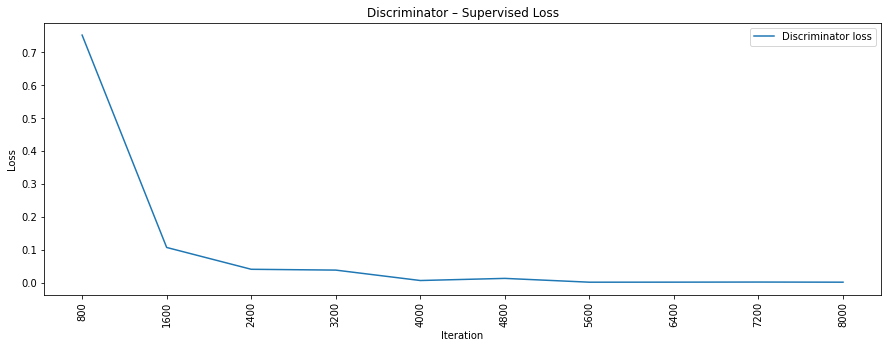

In [20]:
losses = np.array(supervised_losses)

# 판별자의 지도 학습 손실을 그립니다.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

**모델 훈련과 테스트 정확도**

In [21]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 15ms/step - loss: 1.6770e-04 - accuracy: 1.0000
Training Accuracy: 100.00%


In [22]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.9124
Test Accuracy: 91.24%


## 7.3 지도 학습 분류기와 비교하기

In [23]:
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [24]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

# 분류기를 훈련합니다.
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 1s 21ms/step - loss: 2.2963 - accuracy: 0.1400
Epoch 2/30
4/4 [==============================] - 0s 7ms/step - loss: 2.1812 - accuracy: 0.2600
Epoch 3/30
4/4 [==============================] - 0s 7ms/step - loss: 2.0933 - accuracy: 0.3600
Epoch 4/30
4/4 [==============================] - 0s 7ms/step - loss: 1.9868 - accuracy: 0.4800
Epoch 5/30
4/4 [==============================] - 0s 7ms/step - loss: 1.8129 - accuracy: 0.5000
Epoch 6/30
4/4 [==============================] - 0s 7ms/step - loss: 1.5789 - accuracy: 0.6400
Epoch 7/30
4/4 [==============================] - 0s 6ms/step - loss: 1.3326 - accuracy: 0.7200
Epoch 8/30
4/4 [==============================] - 0s 7ms/step - loss: 1.0282 - accuracy: 0.8200
Epoch 9/30
4/4 [==============================] - 0s 6ms/step - loss: 0.7939 - accuracy: 0.8000
Epoch 10/30
4/4 [==============================] - 0s 7ms/step - loss: 0.6294 - accuracy: 0.7900
Epoch 11/30
4/4 [=====================

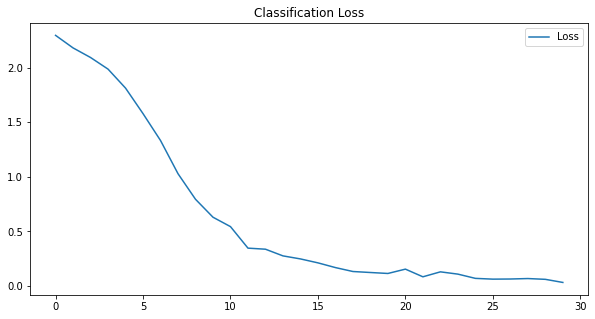

In [25]:
# 분류 손실
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

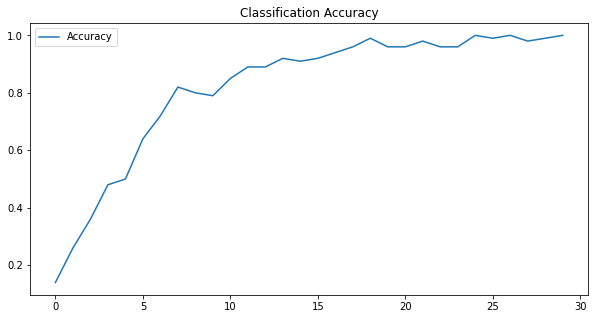

In [26]:
# 분류 정확도
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

In [27]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 5ms/step - loss: 0.0121 - accuracy: 1.0000
Training Accuracy: 100.00%


In [28]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.2415 - accuracy: 0.7019
Test Accuracy: 70.19%
